# <font color=red>Image classifier notebook</font>

<font>**Aim:**</font>
Demonstrate the workflow designed by Pete Bunting in rsgislib  for applying any sklearn classifier. This will serve as quick comparison of classifiers.
https://www.rsgislib.org/rsgislib_classification.html?highlight=applyclassifer#rsgislib.classification.classimgutils.applyClassifer


<font>**Basic Structure:**</font>
- get DEA data, export as tif
- extract and collate training data for model
- train and apply classifiers
- plot data

<font>**Extras:**</font>
- can use multiple image inputs for classification
- using this as a workflow for DEA would require modifying rsgislib functions to avoid input/output of data
- to get this working straight away, training data can be found in `/g/data/r78/LCCS_Aberystwyth/co6850/chris_leaust_testing/notebooks/level3/image_classifier/training_data`

In [79]:
import sys
import os
import xarray as xr

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
dc = datacube.Datacube(app="image_classifier")

import rsgislib
from rsgislib import imageutils
from rsgislib import vectorutils
from rsgislib.classification import classimgutils

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

os.makedirs('./image_classifier', exist_ok=True)

In [52]:
# Datacube inputs
res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
sensor = 'ls8'

# Define area of interest (using dict so you can add lots of sites 
# and run in loop for training and classification below)
Ayr = {'AOI': 'Ayr', 
       'query': {'x':(1500000, 1600000), 'y':(-2200000, -2100000), 
                 'resolution': res, 'time': time, 'crs': crs},
       'image': 'image_classifier/Ayr_geomedian_2015.tif',
       'natVec': 'image_classifier/training_data/Ayr_nat.shp',
       'cultVec': 'image_classifier/training_data/Ayr_cult.shp'}

Mt_Ney = {'AOI': 'Mt_Ney', 
       'query': {'x':(-1000000, -900000), 'y':(-3650000, -3550000), 
                 'resolution': res, 'time': time, 'crs': crs},
       'image': 'image_classifier/Mt_Ney_geomedian_2015.tif',
       'natVec': 'image_classifier/training_data/Mt_Ney_nat.shp',
       'cultVec': 'image_classifier/training_data/Mt_Ney_cult.shp'}

sites = [Ayr]

In [53]:
# input image from DEA and export for rsgislib functions
geomedian = dc.load(product=sensor + "_nbart_geomedian_annual", **Ayr['query'])
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')

for site in sites:
    write_geotiff(filename='image_classifier/'+site['AOI']+'_geomedian_2015.tif', dataset=geomedian)

In [54]:
# Lists to combine training data from different sites
natInTrainSamples = []
cultInTrainSamples = []

# The number of pixels to be sampled from each training class
nSamples = 100

# Two functions to extract training data, in this case natural(nat) and cultivated(cult),
# from DEA output dataset based on shapefiles
def nat_training_model(AOI, image, natVec):
    natImg = 'image_classifier/natImg_temp.kea'
    natImgSamp = 'image_classifier/natImgSamp_temp.kea'
    natPxlTrainVals = 'image_classifier/natPxlTrainVals_'+AOI+'.h5'

    vectorutils.rasterise2Image(natVec, image, natImg, 
                            gdalformat='KEA', burnVal=1)
    imageutils.performRandomPxlSampleInMaskLowPxlCount(inputImage=natImg, 
                                                   outputImage=natImgSamp, 
                                                   gdalformat='KEA', maskvals=[1], 
                                                   numSamples=nSamples)
    imgFileInfo = [imageutils.ImageBandInfo(image, 'geomedian', [1,2,3,4,5,6])]
    imageutils.extractZoneImageBandValues2HDF(imgFileInfo, natImgSamp, 
                                          natPxlTrainVals, 1.0)
    natInTrainSamples.append(natPxlTrainVals)
    os.remove(natImg)
    os.remove(natImgSamp)
    return natInTrainSamples

def cult_training_model(AOI, image, cultVec):
    cultImg = 'image_classifier/cultImg_temp.kea'
    cultImgSamp = 'image_classifier/cultImgSamp_temp.kea'
    cultPxlTrainVals = 'image_classifier/cultPxlTrainVals_'+AOI+'.h5'

    vectorutils.rasterise2Image(cultVec, image, cultImg, 
                            gdalformat='KEA', burnVal=2)
    imageutils.performRandomPxlSampleInMaskLowPxlCount(inputImage=cultImg, 
                                                   outputImage=cultImgSamp, 
                                                   gdalformat='KEA', maskvals=[2], 
                                                   numSamples=nSamples)
    imgFileInfo = [imageutils.ImageBandInfo(image, 'geomedian', [1,2,3,4,5,6])]
    imageutils.extractZoneImageBandValues2HDF(imgFileInfo, cultImgSamp, 
                                          cultPxlTrainVals, 2.0)
    cultInTrainSamples.append(cultPxlTrainVals)
    os.remove(cultImg)
    os.remove(cultImgSamp)
    return cultInTrainSamples


In [56]:
# Combine training data in .h5 files to create models
for site in sites:
    nat_training_model(site['AOI'], site['image'], site['natVec'])
    natTrainSamples = 'natTrainSamples.h5'
    rsgislib.imageutils.mergeExtractedHDF5Data(natInTrainSamples, natTrainSamples)

    cult_training_model(site['AOI'], site['image'], site['cultVec'])
    cultTrainSamples = 'cultTrainSamples.h5'
    rsgislib.imageutils.mergeExtractedHDF5Data(cultInTrainSamples, cultTrainSamples)

classTrainInfo = dict()
classTrainInfo['nat'] = classimgutils.ClassInfoObj(id=1, fileH5=natTrainSamples, 
                                                     red=0, green=153, blue=0)
classTrainInfo['cult'] = classimgutils.ClassInfoObj(id=2, fileH5=cultTrainSamples, 
                                                     red=192, green=192, blue=192)
# remove intermediate h5 files
for site in sites:
    AOI = site['AOI']
    natPxlTrainVals = 'image_classifier/natPxlTrainVals_'+AOI+'.h5'
    os.remove(natPxlTrainVals)
    cultPxlTrainVals = 'image_classifier/cultPxlTrainVals_'+AOI+'.h5'
    os.remove(cultPxlTrainVals)    

Creating output image using input image
Running Rasterise now...
Adding Colour Table
Completed
Creating output image using input image
Running Rasterise now...
Adding Colour Table
Completed


In [83]:
# Valid mask required - just using test site polygons
validVecMsk = '../../level3_test_sites.gpkg'

# Train and Apply classifiers
# rsgislib applyclassifier allows any scikit-learn classifier in the library
def RandomForest_classifier(image, outImgClass):
    validImgMsk = 'image_classifier/AOImask_temp.kea'
    skClassifier = RandomForestClassifier(n_estimators=100)
    classimgutils.trainClassifier(classTrainInfo, skClassifier)
    vectorutils.rasterise2Image(validVecMsk, image, validImgMsk, 
                                gdalformat='KEA', burnVal=1)
    imgFileInfo = [imageutils.ImageBandInfo(image, 'geomedian', [1,2,3,4,5,6])]
    classimgutils.applyClassifer(classTrainInfo, skClassifier, validImgMsk, 1,
                                 imgFileInfo, outImgClass, 'KEA')
    os.remove(validImgMsk)

def ExtraTrees_classifier(image, outImgClass):
    validImgMsk = 'image_classifier/AOImask_temp.kea'
    skClassifier = ExtraTreesClassifier(n_estimators=100)
    classimgutils.trainClassifier(classTrainInfo, skClassifier)
    vectorutils.rasterise2Image(validVecMsk, image, validImgMsk, 
                                gdalformat='KEA', burnVal=1)
    imgFileInfo = [imageutils.ImageBandInfo(image, 'geomedian', [1,2,3,4,5,6])]
    classimgutils.applyClassifer(classTrainInfo, skClassifier, validImgMsk, 1,
                                 imgFileInfo, outImgClass, 'KEA')
    os.remove(validImgMsk)

def GradientBoosting_classifier(image, outImgClass):
    validImgMsk = 'image_classifier/AOImask_temp.kea'
    skClassifier = GradientBoostingClassifier(n_estimators=100)
    classimgutils.trainClassifier(classTrainInfo, skClassifier)
    vectorutils.rasterise2Image(validVecMsk, image, validImgMsk, 
                                gdalformat='KEA', burnVal=1)
    imgFileInfo = [imageutils.ImageBandInfo(image, 'geomedian', [1,2,3,4,5,6])]
    classimgutils.applyClassifer(classTrainInfo, skClassifier, validImgMsk, 1,
                                 imgFileInfo, outImgClass, 'KEA')
    os.remove(validImgMsk)

def DecisionTree_classifier(image, outImgClass):
    validImgMsk = 'image_classifier/AOImask_temp.kea'
    skClassifier = DecisionTreeClassifier(random_state=None)
    classimgutils.trainClassifier(classTrainInfo, skClassifier)
    vectorutils.rasterise2Image(validVecMsk, image, validImgMsk, 
                                gdalformat='KEA', burnVal=1)
    imgFileInfo = [imageutils.ImageBandInfo(image, 'geomedian', [1,2,3,4,5,6])]
    classimgutils.applyClassifer(classTrainInfo, skClassifier, validImgMsk, 1,
                                 imgFileInfo, outImgClass, 'KEA')
    os.remove(validImgMsk)
    
for site in sites:
    # RandomForest
    outImgClass = 'image_classifier/'+site['AOI']+'_classifiedRF.kea'
    RandomForest_classifier(site['image'], outImgClass)
    # ExtraTrees
    outImgClass = 'image_classifier/'+site['AOI']+'_classifiedET.kea'
    ExtraTrees_classifier(site['image'], outImgClass)
    # GradientBoosting
    outImgClass = 'image_classifier/'+site['AOI']+'_classifiedGB.kea'
    ExtraTrees_classifier(site['image'], outImgClass)
    # DecisionTree
    outImgClass = 'image_classifier/'+site['AOI']+'_classifiedDT.kea'
    DecisionTree_classifier(site['image'], outImgClass)   

Training data size: 390 x 6
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 100.0%
Creating output image using input image
Running Rasterise now...
Adding Colour Table
Completed
Applying the Classifier
Completed
Apply Colour to class 'nat'
Apply Colour to class 'cult'


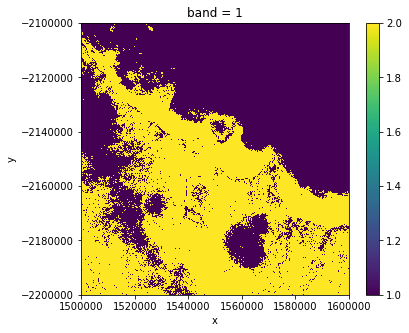

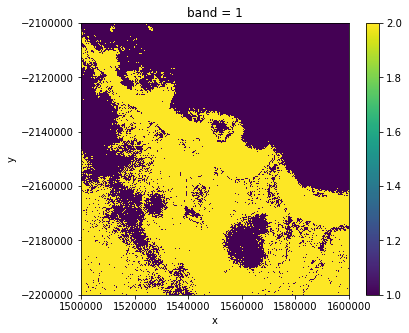

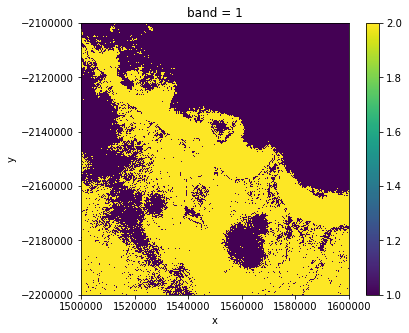

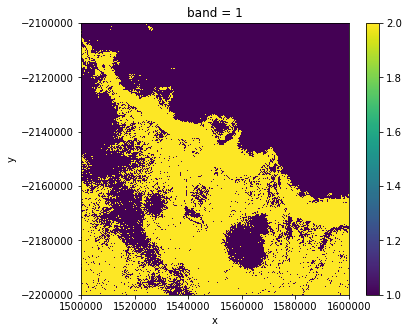

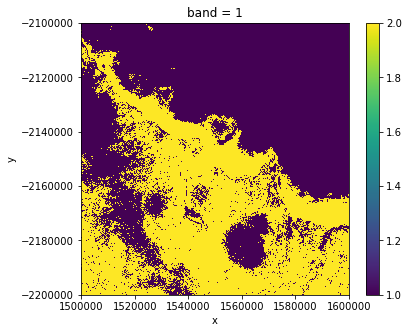

In [84]:
# Open and plot classified images
result = xr.open_rasterio('image_classifier/'+site['AOI']+'_classifiedRF.kea')
result.plot(figsize=(6, 5))
result = xr.open_rasterio('image_classifier/'+site['AOI']+'_classifiedET.kea')
result.plot(figsize=(6, 5))
result = xr.open_rasterio('image_classifier/'+site['AOI']+'_classifiedGB.kea')
result.plot(figsize=(6, 5))
result = xr.open_rasterio('image_classifier/'+site['AOI']+'_classifiedDT.kea')
result.plot(figsize=(6, 5))